In [1]:
#pip install pyamg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pyamg
import scipy.sparse.linalg as sla
import numpy as np
import time

# Load the sparse matrix

In [3]:
A = pyamg.gallery.poisson((50,40,10), format='csr')
n = A.shape[0]
b = np.ones((n,))
x = A * b
x0 = np.random.rand(n)
print(A.nnz)

134200


# Create ILU and LU

Here we will generate the ILU/LU using difference reorderings `permc_spec`

In [4]:
t = time.time()
B = sla.spilu(A, fill_factor=3)#, permc_spec='NATURAL')
tilu = time.time() - t

t = time.time()
C = sla.splu(A.tocsc())#, permc_spec='NATURAL')
tlu = time.time() - t

Mz = lambda r: B.solve(r)
Minv = sla.LinearOperator(A.shape, Mz)

print("nnz in A: %d"%A.nnz)
print("nnz in B: %d"%B.nnz)
print("nnz in C: %d"%C.nnz)
print("time for ILU: %g"%tilu)
print("time for  LU: %g"%tlu)

/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:506: SparseEfficiencyWarning: spilu converted its input to CSC format
  warn('spilu converted its input to CSC format',


nnz in A: 134200
nnz in B: 405872
nnz in C: 10328414
time for ILU: 0.146354
time for  LU: 1.26823


# Check out the sparsity

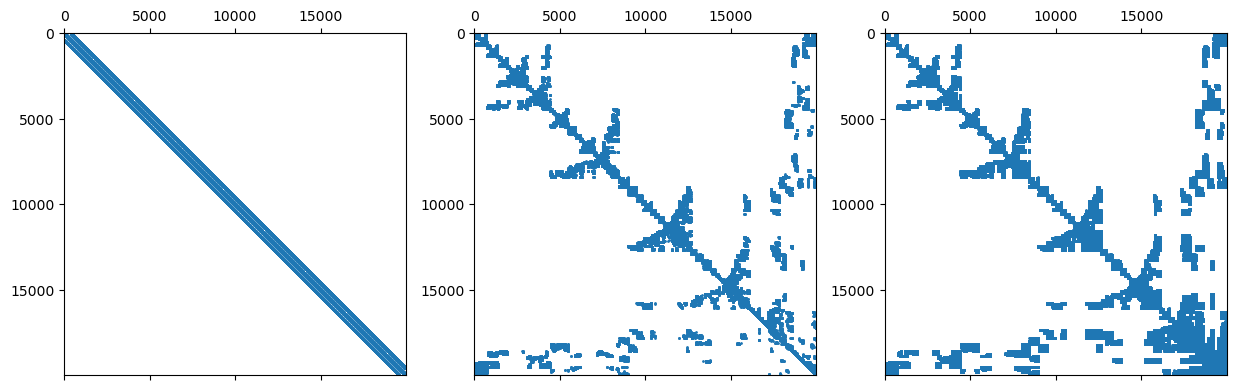

In [5]:
f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].spy(A, marker='.', ms=2)
ax[1].spy(B.L + B.U, marker='.', ms=2)
ax[2].spy(C.L + C.U, marker='.', ms=2)

# How fast is the application of the preconditioner?

In [6]:
t = time.time()
Minv.matvec(b)
tspmv = time.time() - t
print("time to solve: %g"%tspmv)

time to solve: 0.00880694


#### What is the equivalant number of SpMVs?

In [7]:
tilu / tspmv

16.61801889601776

# RUN GMRES vs PGMRES

In [8]:
res0 = []
t = time.time()
x = pyamg.krylov.gmres(A, b, x0=x0, tol=1e-6, restrt=100, maxiter=100, M=None, residuals=res0)
t = time.time() - t
print("time for  gmres: %g"%t)
res1 = []
t = time.time()
x = pyamg.krylov.gmres(A, b, x0=x0, tol=1e-6, restrt=100, maxiter=100, M=Minv, residuals=res1)
t = time.time() - t
print("time for pgmres: %g"%t)


time for  gmres: 0.160187
time for pgmres: 0.0957031


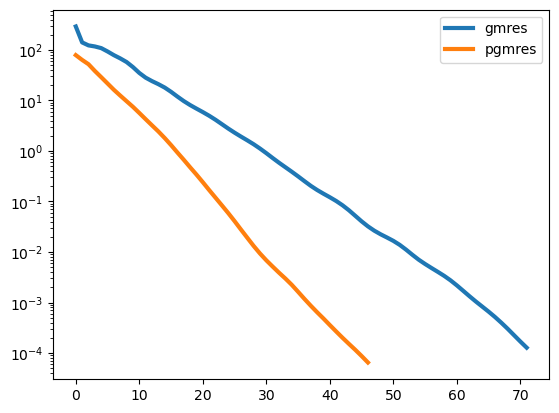

In [10]:
plt.semilogy(res0, lw=3, label='gmres')
plt.semilogy(res1, lw=3, label='pgmres')
plt.legend()

# Notice how pGMRES and GMRES don't start at the same residual (even though x0 = x0 in both); this is because ...
# we have the residual from the preconditioned linear system. So we aren't comparing the same problem. Additionally...
# the per iteration cost is not the same as we have to deal with the preconditioner every time. So sure pGMRES...
# converges in less iterations, but it might take more time!!

In [11]:
print("residual of the original system", np.linalg.norm(A@x[0]-b))

residual of the original system 0.00022057350693679086


In [12]:
print("residual of the original system", np.linalg.norm(B.solve(A@x[0]-b)))

residual of the original system 6.512597851696967e-05


# Now vary the parameters

Two parameters play a role here:
`fill_factor`
and
`drop_tol`

/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:506: SparseEfficiencyWarning: spilu converted its input to CSC format
  warn('spilu converted its input to CSC format',


nnz in A: 134200
nnz in A: 790965
time for    ILU: 0.191714
time for pgmres: 0.0830581


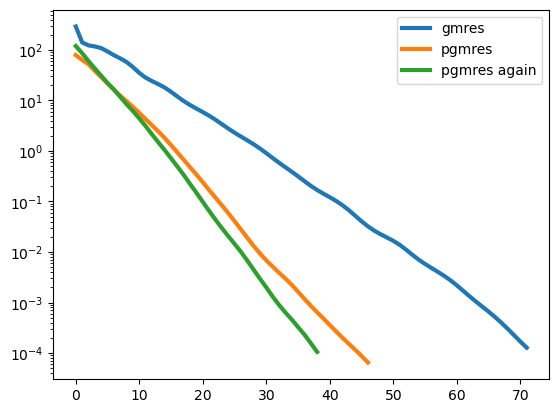

In [13]:
t = time.time()
B = sla.spilu(A, fill_factor=6)
tilu = time.time() - t

Mz = lambda r: B.solve(r)
Minv = sla.LinearOperator(A.shape, Mz)

res2 = []
t = time.time()
x = pyamg.krylov.gmres(A, b, x0=x0, tol=1e-6, restrt=50, maxiter=100, M=Minv, residuals=res2)
t = time.time() - t

print("nnz in A: %d"%A.nnz)
print("nnz in A: %d"%B.nnz)
print("time for    ILU: %g"%tilu)
print("time for pgmres: %g"%t)

plt.semilogy(res0, lw=3, label='gmres')
plt.semilogy(res1, lw=3, label='pgmres')
plt.semilogy(res2, lw=3, label='pgmres again')
plt.legend()

# algebraic multigrid

0.11941695213317871


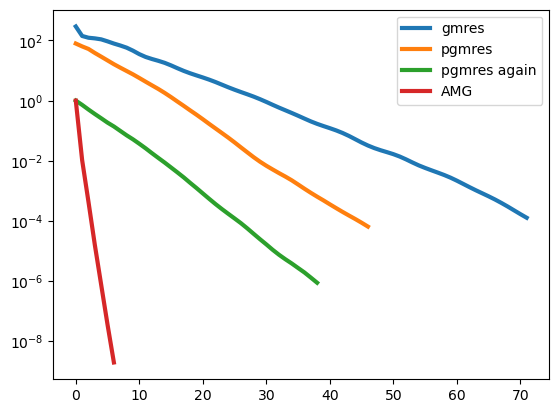

In [14]:
t = time.time()
ml = pyamg.smoothed_aggregation_solver(A, max_coarse=10)
resmg = []
x = ml.solve(b, x0=x0, residuals=resmg, accel='gmres', tol=1e-8)
t = time.time() - t

print(t)
res2 = np.array(res2) / res2[0]
resmg = np.array(resmg) / resmg[0]
plt.semilogy(res0, lw=3, label='gmres')
plt.semilogy(res1, lw=3, label='pgmres')
plt.semilogy(res2, lw=3, label='pgmres again')
plt.semilogy(resmg, lw=3, label='AMG')
plt.legend()